In [1]:
import copy
import gc
import random
import time

import numpy as np
import torch
import torch.multiprocessing as mp
import torch.nn.functional as F
from torch.nn.parallel import DistributedDataParallel

from app.vjepa.transforms import make_transforms
from app.vjepa.utils import init_opt, init_video_model, load_checkpoint, init_video_model_clean
from src.datasets.data_manager import init_data, init_data_miniimagenet
from src.masks.multiseq_multiblock3d import MaskCollator, MiniImagenetCollator
from src.masks.utils import apply_masks
from src.utils.distributed import init_distributed
from src.utils.logging import AverageMeter, CSVLogger, get_logger, gpu_timer
from tqdm import tqdm

/home/radientinst_gmail_com/vjepa2/.venv/lib/python3.10/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


[WARNING ][2025-08-09 02:59:21][root                ][_maybe_select_default_device] libtpu.so and TPU device found. Setting PJRT_DEVICE=TPU.


In [2]:
from src.models.utils.patch_embed import PatchEmbed
import torch_xla.core.xla_model as xm

device = 'xla'
    
p_embed = PatchEmbed()
p_embed.to(device)

PatchEmbed(
  (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
)

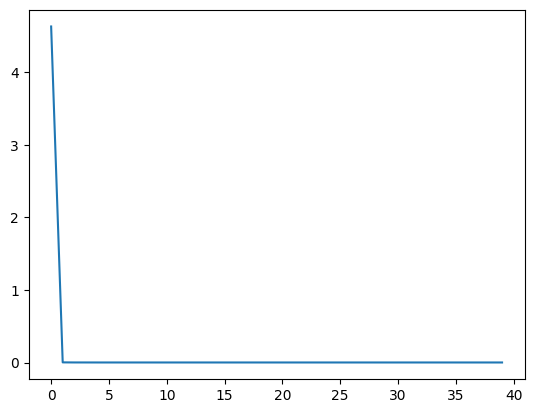

Fastest iteration is 12836.13540290621 times faster than slowest iteration


In [3]:
def test_model(model, inputs):
    """
    inputs is a dict that goes to the model forward pass
    """
    outputs = model(inputs)
    xm.mark_step()
    return outputs

def measure_time(iterations, model):
    exec_times = []

    for i in range(iterations):
        inputs = torch.randn(4, 3, 224, 224).to(device)
        start = time.time()
        outputs = test_model(model, inputs)
        end = time.time()
        exec_times.append(end - start)
    return exec_times

exect_times = measure_time(40, p_embed)
from matplotlib import pyplot as plt
plt.plot(exect_times)
plt.show()
print(f"Fastest iteration is {max(exect_times) / min(exect_times)} times faster than slowest iteration")

In [4]:
from src.models.utils.patch_embed import PatchEmbed3D
p_embed_3d = PatchEmbed3D()
p_embed_3d.to(device)

PatchEmbed3D(
  (proj): Conv3d(3, 768, kernel_size=(2, 16, 16), stride=(2, 16, 16))
)

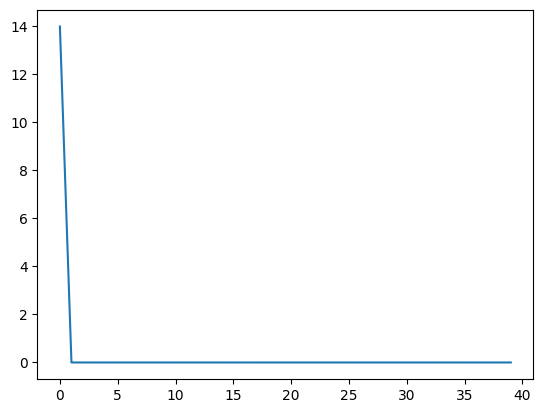

Fastest iteration is 19663.479571332886 times faster than slowest iteration


In [5]:
def test_model(model, inputs):
    """
    inputs is a dict that goes to the model forward pass
    """
    outputs = model(inputs)
    xm.mark_step()
    return outputs

def measure_time(iterations, model):
    exec_times = []
    for i in range(iterations):
        inputs = torch.randn(4, 3, 16, 224, 224).to(device)
        start = time.time()
        outputs = test_model(model, inputs)
        end = time.time()
        exec_times.append(end - start)
    return exec_times

exect_times = measure_time(40, p_embed_3d)
from matplotlib import pyplot as plt
plt.plot(exect_times)
plt.show()
print(f"Fastest iteration is {max(exect_times) / min(exect_times)} times faster than slowest iteration")

In [6]:
from src.models.utils.modules import Attention
attention_model = Attention(dim=64, num_heads=8)
attention_model.to(device)

Attention(
  (qkv): Linear(in_features=64, out_features=192, bias=False)
  (attn_drop): Dropout(p=0.0, inplace=False)
  (proj): Linear(in_features=64, out_features=64, bias=True)
  (proj_drop): Dropout(p=0.0, inplace=False)
)

/usr/lib/python3.10/contextlib.py:103: FutureWarning: `torch.backends.cuda.sdp_kernel()` is deprecated. In the future, this context manager will be removed. Please see `torch.nn.attention.sdpa_kernel()` for the new context manager, with updated signature.
  self.gen = func(*args, **kwds)


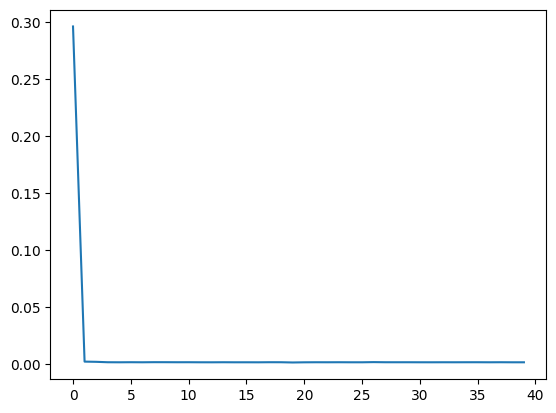

Fastest iteration is 201.07336032388665 times faster than slowest iteration


In [7]:


def test_model(model, inputs):
    """
    inputs is a dict that goes to the model forward pass
    """
    outputs = model(inputs)
    xm.mark_step()
    return outputs

def measure_time(iterations, model):
    exec_times = []
    
    # inputs = {
    #     'x': torch.randn(4, 8, 256, 1024).to(device),
    #     'pos': torch.randn(4, 256, 1024).to(device),
    # }

    for i in range(iterations):
        inputs = torch.randn(4, 256, 64).to(device)
        start = time.time()
        outputs = test_model(model, inputs)
        end = time.time()
        exec_times.append(end - start)
    return exec_times

exect_times = measure_time(40, attention_model)
from matplotlib import pyplot as plt
plt.plot(exect_times)
plt.show()
print(f"Fastest iteration is {max(exect_times) / min(exect_times)} times faster than slowest iteration")

In [8]:
from src.models.utils.modules import Block
block_model = Block(dim=64, num_heads=8)
block_model.to(device)

Block(
  (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  (attn): Attention(
    (qkv): Linear(in_features=64, out_features=192, bias=False)
    (attn_drop): Dropout(p=0.0, inplace=False)
    (proj): Linear(in_features=64, out_features=64, bias=True)
    (proj_drop): Dropout(p=0.0, inplace=False)
  )
  (drop_path): Identity()
  (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  (mlp): MLP(
    (fc1): Linear(in_features=64, out_features=256, bias=True)
    (act): GELU(approximate='none')
    (fc2): Linear(in_features=256, out_features=64, bias=True)
    (drop): Dropout(p=0.0, inplace=False)
  )
)

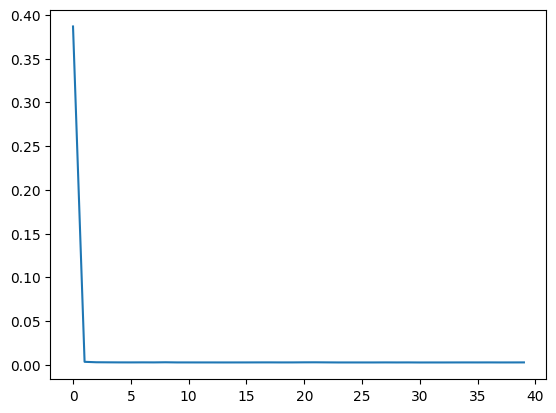

Fastest iteration is 149.26853725850967 times faster than slowest iteration


In [9]:
def test_model(model, inputs):
    """
    inputs is a dict that goes to the model forward pass
    """
    outputs = model(inputs)
    xm.mark_step()
    return outputs

def measure_time(iterations, model):
    exec_times = []
    
    # inputs = {
    #     'x': torch.randn(4, 8, 256, 1024).to(device),
    #     'pos': torch.randn(4, 256, 1024).to(device),
    # }

    for i in range(iterations):
        inputs = torch.randn(4, 256, 64).to(device)
        start = time.time()
        outputs = test_model(model, inputs)
        end = time.time()
        exec_times.append(end - start)
    return exec_times

exect_times = measure_time(40, block_model)
from matplotlib import pyplot as plt
plt.plot(exect_times)
plt.show()
print(f"Fastest iteration is {max(exect_times) / min(exect_times)} times faster than slowest iteration")

In [10]:
from src.models.vision_transformer import VisionTransformer
vit_model = VisionTransformer()
vit_model.to(device)

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  )
  (blocks): ModuleList(
    (0-11): 12 x Block(
      (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (mlp): MLP(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
)

In [11]:
(torch.randn(32,256)<0.5).shape

torch.Size([32, 256])

tensor(39, device='xla:0')


tensor(25, device='xla:0')
tensor(45, device='xla:0')
tensor(31, device='xla:0')
tensor(27, device='xla:0')
tensor(41, device='xla:0')
tensor(37, device='xla:0')
tensor(37, device='xla:0')
tensor(45, device='xla:0')
tensor(38, device='xla:0')
tensor(45, device='xla:0')
tensor(32, device='xla:0')
tensor(43, device='xla:0')
tensor(37, device='xla:0')
tensor(41, device='xla:0')
tensor(46, device='xla:0')
tensor(38, device='xla:0')
tensor(33, device='xla:0')
tensor(40, device='xla:0')
tensor(36, device='xla:0')
tensor(45, device='xla:0')
tensor(32, device='xla:0')
tensor(47, device='xla:0')
tensor(38, device='xla:0')
tensor(35, device='xla:0')
tensor(39, device='xla:0')
tensor(43, device='xla:0')
tensor(34, device='xla:0')
tensor(43, device='xla:0')
tensor(39, device='xla:0')
tensor(32, device='xla:0')
tensor(38, device='xla:0')
tensor(34, device='xla:0')
tensor(41, device='xla:0')
tensor(33, device='xla:0')
tensor(47, device='xla:0')
tensor(43, device='xla:0')
tensor(47, device='xla:0')
t

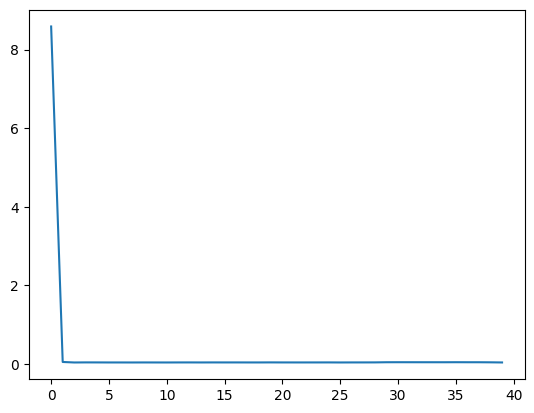

Fastest iteration is 222.6035950862623 times faster than slowest iteration


In [12]:
def test_model(model, inputs):
    """
    inputs is a dict that goes to the model forward pass
    """
    outputs = model(**inputs)
    xm.mark_step()
    return outputs

def measure_time(iterations, model):
    exec_times = []
    # inputs = torch.randn(32, 3, 224, 224).to(device)
    # masks = torch.randn(32,256)<0.5


    for i in range(iterations):
        inputs = {
            'x': torch.randn(4, 3, 224, 224).to(device),
            'masks': (torch.rand(4,196)<0.05).to(device)
        }

        print(inputs['masks'].sum())
        start = time.time()
        outputs = test_model(model, inputs)
        end = time.time()
        exec_times.append(end - start)
    return exec_times

exect_times = measure_time(40, vit_model)
from matplotlib import pyplot as plt
plt.plot(exect_times)
plt.show()
print(f"Fastest iteration is {max(exect_times) / min(exect_times)} times faster than slowest iteration")

In [29]:
torch.sum(torch.randn(4,196)<1)

tensor(660)

In [38]:
torch.rand(4,196).max()

tensor(0.9998)

In [7]:
from src.models.utils.modules import rotate_queries_or_keys

def test_model(model, inputs):
    """
    inputs is a dict that goes to the model forward pass
    """
    outputs = model(**inputs)
    xm.mark_step()
    return outputs

def measure_time(iterations, model):
    exec_times = []
    inputs = {
        'x': torch.randn(4, 8, 256, 1024).to(device),
        'pos': torch.randn(4, 256, 1024).to(device),
    }

    for i in range(iterations):
        start = time.time()
        outputs = test_model(model, inputs)
        end = time.time()
        exec_times.append(end - start)
    return exec_times

exect_times = measure_time(40, rotate_queries_or_keys)
from matplotlib import pyplot as plt
plt.plot(exect_times)
plt.show()
print(f"Fastest iteration is {max(exect_times) / min(exect_times)} times faster than slowest iteration")

RuntimeError: torch_xla/csrc/helpers.cpp:619 : Check failed: dim1 == dim2 || dim1 == 1 || dim2 == 1 || dim1 == xla::Shape::kUnboundedSize || dim2 == xla::Shape::kUnboundedSize 
*** Begin stack trace ***
	tsl::CurrentStackTrace[abi:cxx11]()
	torch_xla::XlaHelpers::GetPromotedShape(xla::Shape const&, xla::Shape const&)
	torch_xla::XlaHelpers::PromoteShapes(xla::XlaOp, xla::XlaOp)
	torch_xla::XlaHelpers::Promote(xla::XlaOp, xla::XlaOp)
	torch_xla::BuildMul(xla::XlaOp, xla::XlaOp)
	
	torch_xla::InferOutputShape(absl::lts_20230802::Span<xla::Shape const>, std::function<xla::XlaOp (absl::lts_20230802::Span<xla::XlaOp const>)> const&)
	
	
	torch_xla::XlaNode::GetOpShape(std::function<xla::Shape ()> const&) const
	torch_xla::XlaNode::XlaNode(torch::lazy::OpKind, c10::ArrayRef<torch::lazy::Value>, std::function<xla::Shape ()> const&, unsigned long, torch::lazy::hash_t)
	torch_xla::Generic::Generic(torch::lazy::OpKind, c10::ArrayRef<torch::lazy::Value>, std::function<xla::Shape ()> const&, std::function<absl::lts_20230802::InlinedVector<xla::XlaOp, 1ul, std::allocator<xla::XlaOp> > (torch_xla::XlaNode const&, torch_xla::LoweringContext*)>, unsigned long, torch::lazy::hash_t)
	std::shared_ptr<torch::lazy::Node> torch_xla::MakeNode<torch_xla::Generic, torch::lazy::OpKind, c10::ArrayRef<torch::lazy::Value>&, std::function<xla::Shape ()> const&, std::function<absl::lts_20230802::InlinedVector<xla::XlaOp, 1ul, std::allocator<xla::XlaOp> > (torch_xla::XlaNode const&, torch_xla::LoweringContext*)>, unsigned long&, torch::lazy::hash_t&>(torch::lazy::OpKind&&, c10::ArrayRef<torch::lazy::Value>&, std::function<xla::Shape ()> const&, std::function<absl::lts_20230802::InlinedVector<xla::XlaOp, 1ul, std::allocator<xla::XlaOp> > (torch_xla::XlaNode const&, torch_xla::LoweringContext*)>&&, unsigned long&, torch::lazy::hash_t&)
	torch_xla::Mul(torch::lazy::Value const&, torch::lazy::Value const&)
	torch_xla::tensor_methods::mul(c10::intrusive_ptr<torch_xla::XLATensor, c10::detail::intrusive_target_default_null_type<torch_xla::XLATensor> > const&, c10::intrusive_ptr<torch_xla::XLATensor, c10::detail::intrusive_target_default_null_type<torch_xla::XLATensor> > const&, std::optional<c10::ScalarType>)
	
	torch_xla::XLANativeFunctions::mul(at::Tensor const&, at::Tensor const&)
	
	
	
	at::_ops::mul_Tensor::redispatch(c10::DispatchKeySet, at::Tensor const&, at::Tensor const&)
	
	
	at::_ops::mul_Tensor::call(at::Tensor const&, at::Tensor const&)
	
	
	
	
	
	
	PyNumber_Multiply
	_PyEval_EvalFrameDefault
	_PyFunction_Vectorcall
	PyObject_Call
	_PyEval_EvalFrameDefault
	_PyFunction_Vectorcall
	_PyEval_EvalFrameDefault
	_PyFunction_Vectorcall
	_PyEval_EvalFrameDefault
	
	PyEval_EvalCode
	
	
	_PyEval_EvalFrameDefault
	
	_PyEval_EvalFrameDefault
	
	_PyEval_EvalFrameDefault
	
	
	
	_PyEval_EvalFrameDefault
	_PyFunction_Vectorcall
	_PyEval_EvalFrameDefault
	_PyFunction_Vectorcall
	_PyEval_EvalFrameDefault
	
	PyObject_Call
	_PyEval_EvalFrameDefault
	
	_PyEval_EvalFrameDefault
	
	_PyEval_EvalFrameDefault
	
	_PyEval_EvalFrameDefault
	
	_PyEval_EvalFrameDefault
	
	_PyEval_EvalFrameDefault
	
	_PyEval_EvalFrameDefault
	
	
	
	
	
	
	
	_PyEval_EvalFrameDefault
	_PyFunction_Vectorcall
	_PyEval_EvalFrameDefault
	_PyFunction_Vectorcall
	_PyEval_EvalFrameDefault
	_PyFunction_Vectorcall
	_PyEval_EvalFrameDefault
	_PyFunction_Vectorcall
	_PyEval_EvalFrameDefault
	_PyFunction_Vectorcall
	_PyEval_EvalFrameDefault
	
	_PyEval_EvalFrameDefault
	
	PyEval_EvalCode
	
	
	_PyEval_EvalFrameDefault
	_PyFunction_Vectorcall
	_PyEval_EvalFrameDefault
	_PyFunction_Vectorcall
	
	Py_RunMain
	Py_BytesMain
	
	__libc_start_main
	_start
*** End stack trace ***


In [2]:
def is_interactive():
    # returns True if the code is running in an interactive environment (e.g. Jupyter notebook)
    try:
        shell = get_ipython().__class__.__name__
        if shell == 'ZMQInteractiveShell':
            return True
        elif shell == 'TerminalInteractiveShell':
            return False
    except NameError:
        return False


In [3]:
import omegaconf

if is_interactive():
    args = omegaconf.OmegaConf.load("/home/radientinst_gmail_com/vjepa2/configs/train/vitl16/pretrain-256px-16f.yaml")

# --
log_timings = True
log_freq = 10
CHECKPOINT_FREQ = 1
GARBAGE_COLLECT_ITR_FREQ = 50
# --

_GLOBAL_SEED = 0
random.seed(_GLOBAL_SEED)
np.random.seed(_GLOBAL_SEED)
torch.manual_seed(_GLOBAL_SEED)
torch.backends.cudnn.benchmark = True
logger = get_logger(__name__, force=True)

# -- META
folder = args.get("folder")
cfgs_meta = args.get("meta")
load_model = cfgs_meta.get("load_checkpoint") or resume_preempt
r_file = cfgs_meta.get("read_checkpoint", None)
seed = cfgs_meta.get("seed", _GLOBAL_SEED)
save_every_freq = cfgs_meta.get("save_every_freq", -1)
skip_batches = cfgs_meta.get("skip_batches", -1)
use_sdpa = cfgs_meta.get("use_sdpa", False)
sync_gc = cfgs_meta.get("sync_gc", False)
which_dtype = cfgs_meta.get("dtype")
logger.info(f"{which_dtype=}")
if which_dtype.lower() == "bfloat16":
    dtype = torch.bfloat16
    mixed_precision = True
elif which_dtype.lower() == "float16":
    dtype = torch.float16
    mixed_precision = True
else:
    dtype = torch.float32
    mixed_precision = False


# -- MASK
cfgs_mask = args.get("mask")

# -- MODEL
cfgs_model = args.get("model")
compile_model = cfgs_model.get("compile_model", False)
use_activation_checkpointing = cfgs_model.get("use_activation_checkpointing", False)
model_name = cfgs_model.get("model_name")
pred_depth = cfgs_model.get("pred_depth")
pred_num_heads = cfgs_model.get("pred_num_heads", None)
pred_embed_dim = cfgs_model.get("pred_embed_dim")
uniform_power = cfgs_model.get("uniform_power", False)
use_mask_tokens = cfgs_model.get("use_mask_tokens", False)
zero_init_mask_tokens = cfgs_model.get("zero_init_mask_tokens", True)
use_rope = cfgs_model.get("use_rope", False)
use_silu = cfgs_model.get("use_silu", False)
use_pred_silu = cfgs_model.get("use_pred_silu", False)
wide_silu = cfgs_model.get("wide_silu", True)

# -- DATA
cfgs_data = args.get("data")
dataset_type = cfgs_data.get("dataset_type", "videodataset")
dataset_paths = cfgs_data.get("datasets", [])
datasets_weights = cfgs_data.get("datasets_weights")
dataset_fpcs = cfgs_data.get("dataset_fpcs")
max_num_frames = 1 # max(dataset_fpcs)
if datasets_weights is not None:
    assert len(datasets_weights) == len(dataset_paths), "Must have one sampling weight specified for each dataset"
batch_size = cfgs_data.get("batch_size")
tubelet_size = 1 # cfgs_data.get("tubelet_size")
fps = cfgs_data.get("fps")
crop_size = cfgs_data.get("crop_size", 224)
patch_size = cfgs_data.get("patch_size")
pin_mem = cfgs_data.get("pin_mem", False)
num_workers = cfgs_data.get("num_workers", 1)
persistent_workers = cfgs_data.get("persistent_workers", True)

# -- DATA AUGS
cfgs_data_aug = args.get("data_aug")
ar_range = cfgs_data_aug.get("random_resize_aspect_ratio", [3 / 4, 4 / 3])
rr_scale = cfgs_data_aug.get("random_resize_scale", [0.3, 1.0])
motion_shift = cfgs_data_aug.get("motion_shift", False)
reprob = cfgs_data_aug.get("reprob", 0.0)
use_aa = cfgs_data_aug.get("auto_augment", False)

# -- LOSS
cfgs_loss = args.get("loss")
loss_exp = cfgs_loss.get("loss_exp")

# -- OPTIMIZATION
cfgs_opt = args.get("optimization")
ipe = cfgs_opt.get("ipe", None)
ipe_scale = cfgs_opt.get("ipe_scale", 1.0)
wd = float(cfgs_opt.get("weight_decay"))
final_wd = float(cfgs_opt.get("final_weight_decay"))
num_epochs = cfgs_opt.get("epochs")
warmup = cfgs_opt.get("warmup")
start_lr = cfgs_opt.get("start_lr")
lr = cfgs_opt.get("lr")
final_lr = cfgs_opt.get("final_lr")
ema = cfgs_opt.get("ema")
betas = cfgs_opt.get("betas", (0.9, 0.999))
eps = cfgs_opt.get("eps", 1.0e-8)
# ----------------------------------------------------------------------- #

[INFO    ][2025-08-08 22:27:55][__main__            ][<module>                 ] which_dtype='float32'


In [4]:
cfgs_mask[0], cfgs_mask[1], dataset_fpcs, tubelet_size

({'aspect_ratio': [0.75, 1.5], 'full_complement': False, 'max_keep': None, 'max_temporal_keep': 1.0, 'num_blocks': 8, 'spatial_scale': [0.15, 0.15], 'temporal_scale': [1.0, 1.0]},
 {'aspect_ratio': [0.75, 1.5], 'full_complement': False, 'max_keep': None, 'max_temporal_keep': 1.0, 'num_blocks': 2, 'spatial_scale': [0.7, 0.7], 'temporal_scale': [1.0, 1.0]},
 [1, 1, 1],
 1)

In [5]:
datasets_weights

[0.335, 0.1, 0.565]

In [6]:

mask_collator = MiniImagenetCollator(
        cfgs_mask=cfgs_mask,
        # dataset_fpcs=dataset_fpcs,
        num_frames=1,
        crop_size=crop_size,
        patch_size=patch_size,
        tubelet_size=tubelet_size,
)

(unsupervised_loader, unsupervised_sampler) = init_data_miniimagenet(
        data=dataset_type,
        root_path=dataset_paths,
        batch_size=batch_size,
        training=True,
        dataset_fpcs=dataset_fpcs,
        fps=fps,
        rank=0,
        world_size=1,
        datasets_weights=None,
        persistent_workers=persistent_workers,
        collator=mask_collator,
        num_workers=num_workers,
        pin_mem=pin_mem,
        log_dir=None,
        path_miniimagenet="/home/radientinst_gmail_com/vjepa/mini-imagenet",
)


[INFO    ][2025-08-08 22:27:56][root                ][make_miniimagenet        ] MiniImagenetDataset dataset created
[INFO    ][2025-08-08 22:27:56][root                ][make_miniimagenet        ] MiniImagenetDataset unsupervised data loader created


In [7]:
loader = iter(unsupervised_loader)
sample = next(loader)
images, labels, masks_enc, masks_pred = sample[0]

/home/radientinst_gmail_com/vjepa2/.venv/lib/python3.10/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/home/radientinst_gmail_com/vjepa2/src/datasets/video_dataset.py:414: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(image).detach().clone(), torch.tensor(one_hot_label).detach().clone()
/home/radientinst_gmail_com/vjepa2/src/datasets/video_dataset.py:414: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(image).detach().clone(), torch.tensor(one_hot_label).detach().clone()
/home/radientinst_gmail_com/vjep

In [8]:
print(images.shape, labels.shape, masks_enc[0].shape, masks_pred[0].shape)

torch.Size([3, 256, 256]) torch.Size([100]) torch.Size([1, 60]) torch.Size([1, 196])


In [9]:
import torch_xla
import torch
import torch.nn as nn
import torch_xla.core.xla_model as xm

device = xm.xla_device()

encoder, predictor = init_video_model_clean(
        uniform_power=uniform_power,
        use_mask_tokens=use_mask_tokens,
        num_mask_tokens=int(len(cfgs_mask) * len(dataset_fpcs)),
        zero_init_mask_tokens=zero_init_mask_tokens,
        device=device,
        patch_size=patch_size,
        max_num_frames=max_num_frames,
        tubelet_size=tubelet_size,
        model_name=model_name,
        crop_size=crop_size,
        pred_depth=pred_depth,
        pred_num_heads=pred_num_heads,
        pred_embed_dim=pred_embed_dim,
        use_sdpa=use_sdpa,
        use_silu=use_silu,
        use_pred_silu=use_pred_silu,
        wide_silu=wide_silu,
        use_rope=use_rope,
        use_activation_checkpointing=use_activation_checkpointing,
    )

target_encoder = copy.deepcopy(encoder)


[INFO    ][2025-08-08 22:28:12][root                ][init_video_model_clean   ] VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
  )
  (blocks): ModuleList(
    (0-23): 24 x Block(
      (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=1024, out_features=3072, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=1024, out_features=1024, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (mlp): MLP(
        (fc1): Linear(in_features=1024, out_features=4096, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=4096, out_features=1024, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (norm): LayerNorm((1024,), eps=1e-06, elem

In [10]:
optimizer, scaler, scheduler, wd_scheduler = init_opt(
        encoder=encoder,
        predictor=predictor,
        wd=wd,
        final_wd=final_wd,
        start_lr=start_lr,
        ref_lr=lr,
        final_lr=final_lr,
        iterations_per_epoch=ipe,
        warmup=warmup,
        num_epochs=num_epochs,
        ipe_scale=ipe_scale,
        mixed_precision=mixed_precision,
        betas=betas,
        eps=eps,
    )

momentum_scheduler = (
        ema[0] + i * (ema[1] - ema[0]) / (ipe * num_epochs * ipe_scale)
        for i in range(int(ipe * num_epochs * ipe_scale) + 1)
    )


In [11]:
def indices_to_bool_mask(index_tensor: torch.Tensor, N: int) -> torch.BoolTensor:
    """
    index_tensor : 1-D or 1×K LongTensor of indices
    N            : total number of patch tokens (grid_h * grid_w * grid_d)
    returns      : [N] bool mask
    """
    idx = index_tensor.view(-1).clamp_(0, N - 1)
    mask = torch.zeros(N, dtype=torch.bool, device=index_tensor.device)
    mask[idx] = True
    return mask

In [15]:
def forward_target(c):
    with torch.no_grad():
        h = target_encoder.forward_image(c)
        h = [F.layer_norm(hi, (hi.size(-1),)) for hi in h]
        h = torch.stack(h, dim=0)
        xm.mark_step()
        return h

def forward_context(c, masks_enc, masks_pred):
    z = encoder(c, masks_enc)
    z = predictor(z, masks_enc, masks_pred)
    # xm.mark_step()
    return z

def load_clips():
    all_clips, all_masks_enc, all_masks_pred = [], [], []
    for fpc_sample in sample:
        udata, labels, masks_enc, masks_pred = fpc_sample
        all_clips += [udata.unsqueeze(0).to(device, non_blocking=True)]
        all_masks_enc += [[m.to(device, non_blocking=True) for m in masks_enc]]
        all_masks_pred += [[m.to(device, non_blocking=True) for m in masks_pred]]
    return all_clips, all_masks_enc, all_masks_pred


def load_clips_xla(sample, device, num_patches):
    """
    num_patches = grid_h * grid_w * grid_d  (same N your ViT uses)
    """
    clips, masks_enc, masks_pred = [], [], []
    for udata, labels, idx_enc_list, idx_pred_list in sample:
        # ---- clip
        clips.append(udata.unsqueeze(0).to(device, non_blocking=True))

        # ---- build *one* boolean mask per sample
        # here we use only the first idx tensor in each list; change if needed
        m_enc_bool  = indices_to_bool_mask(idx_enc_list[0].to(device),  num_patches)
        m_pred_bool = indices_to_bool_mask(idx_pred_list[0].to(device), num_patches)

        masks_enc.append(m_enc_bool)   # each is [N] bool
        masks_pred.append(m_pred_bool) # each is [N] bool

    clips = torch.cat(clips, dim=0)          # [B, 3, H, W] (or video shape)
    masks_enc = torch.stack(masks_enc,  dim=0)   # [B, N] bool
    masks_pred = torch.stack(masks_pred, dim=0)  # [B, N] bool
    return clips, masks_enc, masks_pred


def loss_fn_(z, h, masks_pred_bool, p=1):
    # gather masked positions
    z_masked = z[masks_pred_bool]   # [K, D]
    h_masked = h[masks_pred_bool]   # [K, D]
    loss = (torch.abs(z_masked - h_masked) ** p).mean() / p
    # xm.mark_step()
    return loss

def loss_fn(z, h, masks_pred_bool, p=1):
    """
    z, h              : [B, N, D]  (same static shape every batch)
    masks_pred_bool   : [B, N]     (boolean mask)
    """
    diff   = torch.abs(z - h) ** p                # [B, N, D]
    weight = masks_pred_bool.unsqueeze(-1)        # [B, N, 1] → broadcast

    loss = (diff * weight).sum() / weight.sum() / p
    return loss


In [13]:
num_patches = 256
import torch_xla.debug.metrics as met

In [ ]:
def step(batch):
    clips, m_enc, m_pred = load_clips_xla(batch, device, num_patches)
    z = forward_context(clips, m_enc, m_pred)          # [B,N,D]
    h = forward_target(clips)                          # [L,B,N,D]  (already stacked)
    loss = loss_fn(z, h, m_pred)                   # use last layer
    return loss

# ONE warm-up step (triggers compilation)
loss = step(sample)
loss.backward()          # or loss.item() if you're only evaluating
xm.mark_step() 
print("=== After warm-up ===")
print(met.metrics_report())


/usr/lib/python3.10/contextlib.py:103: FutureWarning: `torch.backends.cuda.sdp_kernel()` is deprecated. In the future, this context manager will be removed. Please see `torch.nn.attention.sdpa_kernel()` for the new context manager, with updated signature.
  self.gen = func(*args, **kwds)


=== After warm-up ===


AttributeError: module 'torch_xla.core.xla_model' has no attribute 'metrics_report'

In [14]:
def step(batch):
    clips, m_enc, m_pred = load_clips_xla(batch, device, num_patches)
    z = forward_context(clips, m_enc, m_pred)          # [B,N,D]
    h = forward_target(clips)                          # [L,B,N,D]  (already stacked)
    loss = loss_fn(z, h, m_pred)                   # use last layer
    loss.backward()
    xm.mark_step()
    return loss

# ONE warm-up step (triggers compilation)
loss = step(sample)

print("=== After warm-up ===")
print(met.metrics_report())

for i in range(1):
    sample = next(loader)
    loss = step(sample)

print("=== After 1 step ===")
print(met.metrics_report())

/usr/lib/python3.10/contextlib.py:103: FutureWarning: `torch.backends.cuda.sdp_kernel()` is deprecated. In the future, this context manager will be removed. Please see `torch.nn.attention.sdpa_kernel()` for the new context manager, with updated signature.
  self.gen = func(*args, **kwds)


=== After warm-up ===
Metric: DeviceLockWait
  TotalSamples: 6
  Accumulator: 081.990us
  ValueRate: 001.236us / second
  Rate: 0.0904434 / second
  Percentiles: 1%=003.229us; 5%=003.229us; 10%=003.229us; 20%=003.408us; 50%=018.886us; 80%=026.226us; 90%=026.292us; 95%=026.292us; 99%=026.292us
Metric: InputOutputAliasCount
  TotalSamples: 3
  Accumulator: 0.00
  ValueRate: 0.00 / second
  Rate: 1.18454 / second
  Percentiles: 1%=0.00; 5%=0.00; 10%=0.00; 20%=0.00; 50%=0.00; 80%=0.00; 90%=0.00; 95%=0.00; 99%=0.00
Metric: IrValueTensorToXlaData
  TotalSamples: 463
  Accumulator: 234ms074.241us
  ValueRate: 020ms017.280us / second
  Rate: 39.5943 / second
  Percentiles: 1%=032.566us; 5%=035.304us; 10%=036.810us; 20%=039.188us; 50%=063.394us; 80%=439.654us; 90%=001ms130.822us; 95%=002ms280.408us; 99%=003ms003.003us
Metric: LazyTracing
  TotalSamples: 26638
  Accumulator: 05s958ms311.466us
  ValueRate: 563ms271.558us / second
  Rate: 16101.2 / second
  Percentiles: 1%=002.641us; 5%=002.818us;

In [ ]:
# warm-up
sample = next(loader)
loss = step(sample)         # uses the new loss_fn
loss.backward()
xm.mark_step()

print(met.metrics_report())  # expect CompileCacheMiss ~= 1

# full epoch
for sample in tqdm(loader):
    loss = step(sample)
    loss.backward()
    xm.mark_step()

print(met.metrics_report())  # CompileCacheMiss should be unchanged


/usr/lib/python3.10/contextlib.py:103: FutureWarning: `torch.backends.cuda.sdp_kernel()` is deprecated. In the future, this context manager will be removed. Please see `torch.nn.attention.sdpa_kernel()` for the new context manager, with updated signature.
  self.gen = func(*args, **kwds)


Metric: DeviceLockWait
  TotalSamples: 48
  Accumulator: 538.794us
  ValueRate: 000.961us / second
  Rate: 0.0856512 / second
  Percentiles: 1%=000.927us; 5%=001.005us; 10%=001.213us; 20%=003.079us; 50%=008.221us; 80%=018.628us; 90%=020.140us; 95%=024.785us; 99%=062.628us
Metric: InputOutputAliasCount
  TotalSamples: 16
  Accumulator: 444.00
  ValueRate: 1.28 / second
  Rate: 0.0461361 / second
  Percentiles: 1%=0.00; 5%=0.00; 10%=0.00; 20%=0.00; 50%=0.00; 80%=0.00; 90%=0.00; 95%=444.00; 99%=444.00
Metric: IrValueTensorToXlaData
  TotalSamples: 531
  Accumulator: 373ms460.369us
  ValueRate: 001ms083.717us / second
  Rate: 1.54087 / second
  Percentiles: 1%=040.646us; 5%=042.479us; 10%=044.386us; 20%=048.019us; 50%=082.443us; 80%=208.962us; 90%=001ms128.382us; 95%=002ms281.327us; 99%=004ms772.357us
Metric: LazyTracing
  TotalSamples: 132558
  Accumulator: 22s467ms160.963us
  ValueRate: 559ms931.328us / second
  Rate: 16239 / second
  Percentiles: 1%=001.245us; 5%=002.398us; 10%=006.830u

  0%|          | 0/12500 [00:00<?, ?it/s]

In [19]:
sample[0][0].max()

tensor(2.6400)

In [25]:
loader = iter(unsupervised_loader)

/home/radientinst_gmail_com/vjepa2/.venv/lib/python3.10/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


/home/radientinst_gmail_com/vjepa2/src/datasets/video_dataset.py:414: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(image).detach().clone(), torch.tensor(one_hot_label).detach().clone()
/home/radientinst_gmail_com/vjepa2/src/datasets/video_dataset.py:414: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(image).detach().clone(), torch.tensor(one_hot_label).detach().clone()
/home/radientinst_gmail_com/vjepa2/src/datasets/video_dataset.py:414: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.ten

In [16]:
for sample in tqdm(loader):
    images_, masks_enc, masks_pred = load_clips_xla(sample, device, num_patches)
    print(images_.shape)
    im = images_
    h = forward_target(im)

  0%|          | 0/12500 [00:00<?, ?it/s]/usr/lib/python3.10/contextlib.py:103: FutureWarning: `torch.backends.cuda.sdp_kernel()` is deprecated. In the future, this context manager will be removed. Please see `torch.nn.attention.sdpa_kernel()` for the new context manager, with updated signature.
  self.gen = func(*args, **kwds)


torch.Size([4, 3, 256, 256])


  0%|          | 1/12500 [00:10<37:04:13, 10.68s/it]

torch.Size([4, 3, 256, 256])


  0%|          | 2/12500 [00:20<36:08:55, 10.41s/it]


RuntimeError: DataLoader worker (pid(s) 103434, 103435, 103436, 103437, 103438, 103439, 103440, 103441) exited unexpectedly

In [33]:
images.shape

torch.Size([3, 256, 256])

In [ ]:
sample = next(loader)
loss = step(sample)
loss.backward()

print("=== Second run ===")
print(met.metrics_report())


In [22]:
sample = next(loader)

In [ ]:
for epoch in range(0, num_epochs):
    loss_meter = AverageMeter()
    mask_meters = {fpc: AverageMeter() for fpc in dataset_fpcs}
    iter_time_meter = AverageMeter()
    gpu_time_meter = AverageMeter()
    data_elapsed_time_meter = AverageMeter()
    
    for itr in tqdm(range(ipe)):    
        itr_start_time = time.time()

        iter_retries = 0
        iter_successful = False
        while not iter_successful:
            try:
                sample = next(loader)
                iter_successful = True
            except StopIteration:
                logger.info("Exhausted data loaders. Refreshing...")
                unsupervised_sampler.set_epoch(epoch)
                loader = iter(unsupervised_loader)
            except Exception as e:
                NUM_RETRIES = 5
                if iter_retries < NUM_RETRIES:
                    logger.warning(f"Encountered exception when loading data (num retries {iter_retries}):\n{e}")
                    iter_retries += 1
                    time.sleep(5)
                else:
                    logger.warning(f"Exceeded max retries ({NUM_RETRIES}) when loading data. Skipping batch.")
                    raise e

        for _fpc_sample in sample:
            bs, fpc = _fpc_sample[-1][0].size()
            mask_meters[1].update(bs / batch_size)

        

        clips, masks_enc, masks_pred = load_clips()
        data_elapsed_time_ms = (time.time() - itr_start_time) * 1000.0

        if sync_gc and (itr + 1) % GARBAGE_COLLECT_ITR_FREQ == 0:
            logger.info("Running garbage collection...")
            gc.collect()

        clips, m_enc, m_pred = load_clips_xla(sample, device, num_patches)

        @torch_xla.step()
        def train_step(clips, m_enc, m_pred):
            _new_lr = scheduler.step()
            _new_wd = wd_scheduler.step()
            # --
            # Step 1. Forward
        
            
            z = forward_context(clips, m_enc, m_pred)          # [B,N,D]
            h = forward_target(clips)                          # [L,B,N,D]  (already stacked)
            loss = loss_fn(z, h, m_pred)                   # use last layer

            loss.backward()
            # optimizer.step()
            # optimizer.zero_grad()

            # Step 3. momentum update of target encoder
            # m = next(momentum_scheduler)
            # with torch.no_grad():
            #     for q, k in zip(encoder.parameters(), target_encoder.parameters()):
            #         k.mul_(m).add_(q, alpha=1 - m)

            # with torch.no_grad():
            #     params_k = []
            #     params_q = []
            #     for param_q, param_k in zip(encoder.parameters(), target_encoder.parameters()):
            #         params_k.append(param_k)
            #         params_q.append(param_q)
            #     torch._foreach_mul_(params_k, m)
            #     torch._foreach_add_(params_k, params_q, alpha=1 - m)
            xm.mark_step()
            return (
                loss,
                _new_lr,
                _new_wd,
            )

        (
            loss,
            _new_lr,
            _new_wd,
        ) = train_step(clips, m_enc, m_pred)


        iter_elapsed_time_ms = (time.time() - itr_start_time) * 1000.0
        loss_meter.update(loss)
        iter_time_meter.update(iter_elapsed_time_ms)
        data_elapsed_time_meter.update(data_elapsed_time_ms)

        # -- Logging
        # def log_stats():
        #     csv_logger.log(epoch + 1, itr, loss, iter_elapsed_time_ms, gpu_etime_ms, data_elapsed_time_ms)
        #     if (itr % log_freq == 0) or (itr == ipe - 1) or np.isnan(loss) or np.isinf(loss):
        #         logger.info(
        #             "[%d, %5d] loss: %.3f "
        #             "masks: %s "
        #             "[wd: %.2e] [lr: %.2e] "
        #             "[mem: %.2e] "
        #             "[iter: %.1f ms] "
        #             "[gpu: %.1f ms] "
        #             "[data: %.1f ms]"
        #             % (
        #                 epoch + 1,
        #                 itr,
        #                 loss_meter.avg,
        #                 "[" + ", ".join([f"{k}: " + "%.1f" % mask_meters[k].avg for k in mask_meters]) + "]",
        #                 _new_wd,
        #                 _new_lr,
        #                 0,
        #                 iter_time_meter.avg,
        #                 gpu_time_meter.avg,
        #                 data_elapsed_time_meter.avg,
        #             )
        #         )

        # log_stats()
        # assert not np.isnan(loss), "loss is nan"

    torch_xla.sync()

    # -- Save Checkpoint
    logger.info("avg. loss %.3f" % loss_meter.avg)
    # -- Save Last
    if epoch % CHECKPOINT_FREQ == 0 or epoch == (num_epochs - 1):
        save_checkpoint(epoch + 1, latest_path)
        if save_every_freq > 0 and epoch % save_every_freq == 0:
            save_every_file = f"e{epoch}.pt"
            save_every_path = os.path.join(folder, save_every_file)
            save_checkpoint(epoch + 1, save_every_path)
    
    

  0%|          | 0/300 [00:00<?, ?it/s]

[WARNING ][2025-08-08 21:33:21][__main__            ][<module>                 ] Encountered exception when loading data (num retries 0):
DataLoader worker (pid(s) 87450, 87451, 87452, 87453, 87454, 87455, 87456, 87457) exited unexpectedly


/usr/lib/python3.10/contextlib.py:103: FutureWarning: `torch.backends.cuda.sdp_kernel()` is deprecated. In the future, this context manager will be removed. Please see `torch.nn.attention.sdpa_kernel()` for the new context manager, with updated signature.
  self.gen = func(*args, **kwds)
  1%|          | 2/300 [02:24<5:56:39, 71.81s/it]

In [ ]:
for epoch in range(0, num_epochs):
    loss_meter = AverageMeter()
    mask_meters = {fpc: AverageMeter() for fpc in dataset_fpcs}
    iter_time_meter = AverageMeter()
    gpu_time_meter = AverageMeter()
    data_elapsed_time_meter = AverageMeter()
    
    for itr in tqdm(range(ipe)):
        with torch_xla.step():
            itr_start_time = time.time()

            iter_retries = 0
            iter_successful = False
            while not iter_successful:
                try:
                    sample = next(loader)
                    iter_successful = True
                except StopIteration:
                    logger.info("Exhausted data loaders. Refreshing...")
                    unsupervised_sampler.set_epoch(epoch)
                    loader = iter(unsupervised_loader)
                except Exception as e:
                    NUM_RETRIES = 5
                    if iter_retries < NUM_RETRIES:
                        logger.warning(f"Encountered exception when loading data (num retries {iter_retries}):\n{e}")
                        iter_retries += 1
                        time.sleep(5)
                    else:
                        logger.warning(f"Exceeded max retries ({NUM_RETRIES}) when loading data. Skipping batch.")
                        raise e

            for _fpc_sample in sample:
                bs, fpc = _fpc_sample[-1][0].size()
                mask_meters[1].update(bs / batch_size)

            def load_clips():
                all_clips, all_masks_enc, all_masks_pred = [], [], []
                for fpc_sample in sample:
                    udata, labels, masks_enc, masks_pred = fpc_sample
                    all_clips += [udata.unsqueeze(0).to(device, non_blocking=True)]
                    all_masks_enc += [[m.to(device, non_blocking=True) for m in masks_enc]]
                    all_masks_pred += [[m.to(device, non_blocking=True) for m in masks_pred]]
                return all_clips, all_masks_enc, all_masks_pred

            clips, masks_enc, masks_pred = load_clips()
            data_elapsed_time_ms = (time.time() - itr_start_time) * 1000.0

            if sync_gc and (itr + 1) % GARBAGE_COLLECT_ITR_FREQ == 0:
                logger.info("Running garbage collection...")
                gc.collect()

            def train_step():
                _new_lr = scheduler.step()
                _new_wd = wd_scheduler.step()
                # --

                def forward_target(c):
                    with torch.no_grad():
                        h = target_encoder(c)
                        h = [F.layer_norm(hi, (hi.size(-1),)) for hi in h]
                        return h

                def forward_context(c):
                    z = encoder(c, masks_enc)
                    z = predictor(z, masks_enc, masks_pred)
                    return z

                def loss_fn(z, h):
                    # Assumption: predictor will have returned only masked tokens for z
                    h = [apply_masks(hi, mi, concat=False) for hi, mi in zip(h, masks_pred)]
                    loss, n = 0, 0
                    for zi, hi in tqdm(zip(z, h)):
                        for zij, hij in zip(zi, hi):
                            loss += torch.mean(torch.abs(zij - hij) ** loss_exp) / loss_exp
                            n += 1
                    loss /= n
                    return loss

                # Step 1. Forward
            
                h = forward_target(clips)
                print(h[0].shape)
                z = forward_context(clips)
                print(z[0][0].shape)
                loss = loss_fn(z, h)  # jepa prediction loss
                print(loss)

                # Step 2. Backward & step
                if mixed_precision:
                    scaler.scale(loss).backward()
                    scaler.unscale_(optimizer)
                else:
                    loss.backward()
                if mixed_precision:
                    scaler.step(optimizer)
                    scaler.update()
                else:
                    optimizer.step()
                optimizer.zero_grad()

                # Step 3. momentum update of target encoder
                m = next(momentum_scheduler)
                with torch.no_grad():
                    for q, k in zip(encoder.parameters(), target_encoder.parameters()):
                        k.mul_(m).add_(q, alpha=1 - m)

                # with torch.no_grad():
                #     params_k = []
                #     params_q = []
                #     for param_q, param_k in zip(encoder.parameters(), target_encoder.parameters()):
                #         params_k.append(param_k)
                #         params_q.append(param_q)
                #     torch._foreach_mul_(params_k, m)
                #     torch._foreach_add_(params_k, params_q, alpha=1 - m)

                print('updated')
                return (
                    float(loss),
                    _new_lr,
                    _new_wd,
                )

            (
                loss,
                _new_lr,
                _new_wd,
            ), gpu_etime_ms = gpu_timer(train_step)
            iter_elapsed_time_ms = (time.time() - itr_start_time) * 1000.0
            loss_meter.update(loss)
            iter_time_meter.update(iter_elapsed_time_ms)
            gpu_time_meter.update(gpu_etime_ms)
            data_elapsed_time_meter.update(data_elapsed_time_ms)

            # -- Logging
            # def log_stats():
            #     csv_logger.log(epoch + 1, itr, loss, iter_elapsed_time_ms, gpu_etime_ms, data_elapsed_time_ms)
            #     if (itr % log_freq == 0) or (itr == ipe - 1) or np.isnan(loss) or np.isinf(loss):
            #         logger.info(
            #             "[%d, %5d] loss: %.3f "
            #             "masks: %s "
            #             "[wd: %.2e] [lr: %.2e] "
            #             "[mem: %.2e] "
            #             "[iter: %.1f ms] "
            #             "[gpu: %.1f ms] "
            #             "[data: %.1f ms]"
            #             % (
            #                 epoch + 1,
            #                 itr,
            #                 loss_meter.avg,
            #                 "[" + ", ".join([f"{k}: " + "%.1f" % mask_meters[k].avg for k in mask_meters]) + "]",
            #                 _new_wd,
            #                 _new_lr,
            #                 0,
            #                 iter_time_meter.avg,
            #                 gpu_time_meter.avg,
            #                 data_elapsed_time_meter.avg,
            #             )
            #         )

            # log_stats()
            assert not np.isnan(loss), "loss is nan"

            torch_xla.sync()

    # -- Save Checkpoint
    logger.info("avg. loss %.3f" % loss_meter.avg)
    # -- Save Last
    if epoch % CHECKPOINT_FREQ == 0 or epoch == (num_epochs - 1):
        save_checkpoint(epoch + 1, latest_path)
        if save_every_freq > 0 and epoch % save_every_freq == 0:
            save_every_file = f"e{epoch}.pt"
            save_every_path = os.path.join(folder, save_every_file)
            save_checkpoint(epoch + 1, save_every_path)
    
    

  0%|          | 0/300 [00:00<?, ?it/s]

torch.Size([1, 256, 1024])
torch.Size([1, 159, 1024])
first h


24it [00:00, 686.84it/s]

tensor(0.7909, grad_fn=<DivBackward0>)


updated


  0%|          | 1/300 [01:08<5:43:04, 68.84s/it]

torch.Size([1, 256, 1024])
torch.Size([1, 151, 1024])
first h


24it [00:00, 1347.17it/s]

tensor(0.7716, grad_fn=<DivBackward0>)


updated


  1%|          | 2/300 [02:23<5:58:46, 72.24s/it]

torch.Size([1, 256, 1024])
torch.Size([1, 166, 1024])
first h


24it [00:00, 1193.60it/s]

tensor(0.7635, grad_fn=<DivBackward0>)


updated


  1%|          | 3/300 [03:35<5:57:43, 72.27s/it]

torch.Size([1, 256, 1024])
torch.Size([1, 162, 1024])
first h


24it [00:00, 1232.92it/s]

tensor(0.7407, grad_fn=<DivBackward0>)


updated


  1%|▏         | 4/300 [04:45<5:52:16, 71.41s/it]

torch.Size([1, 256, 1024])


  1%|▏         | 4/300 [05:11<6:24:39, 77.97s/it]


KeyboardInterrupt: 

In [ ]:
from tqdm import tqdm
for i in tqdm(range(3000)):
    sample = next(loader)
    

 69%|██████▉   | 2082/3000 [04:14<01:52,  8.18it/s]


StopIteration: 

In [ ]:
unsupervised_sampler.set_epoch(epoch)
sample = next(loader)

StopIteration: 

In [ ]:
import torch_xla
import torch
import torch.nn as nn
import torch_xla.core.xla_model as xm

device = xm.xla_device()

encoder, predictor = init_video_model(
        uniform_power=uniform_power,
        use_mask_tokens=use_mask_tokens,
        num_mask_tokens=int(len(cfgs_mask) * len(dataset_fpcs)),
        zero_init_mask_tokens=zero_init_mask_tokens,
        device=device,
        patch_size=patch_size,
        max_num_frames=max_num_frames,
        tubelet_size=tubelet_size,
        model_name=model_name,
        crop_size=crop_size,
        pred_depth=pred_depth,
        pred_num_heads=pred_num_heads,
        pred_embed_dim=pred_embed_dim,
        use_sdpa=use_sdpa,
        use_silu=use_silu,
        use_pred_silu=use_pred_silu,
        wide_silu=wide_silu,
        use_rope=use_rope,
        use_activation_checkpointing=use_activation_checkpointing,
    )

target_encoder = copy.deepcopy(encoder)


[INFO    ][2025-08-05 14:10:21][root                ][init_video_model         ] MultiSeqWrapper(
  (backbone): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-23): 24 x Block(
        (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (attn): RoPEAttention(
          (qkv): Linear(in_features=1024, out_features=3072, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=1024, out_features=1024, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (drop_path): Identity()
        (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (mlp): MLP(
          (fc1): Linear(in_features=1024, out_features=4096, bias=True)
          (act): GELU(approximate='none')
          (fc2): Linear(in_features=4096, out_features=1024, bias=True)
          (drop): Dropout(p=0.0, inpl

In [ ]:
dataset_fpcs

[16, 16, 16]

In [ ]:
inputs = torch.randn(3, 1, 3, 256, 256).to(device)
outputs = encoder.forward(inputs)

/usr/lib/python3.10/contextlib.py:103: FutureWarning: `torch.backends.cuda.sdp_kernel()` is deprecated. In the future, this context manager will be removed. Please see `torch.nn.attention.sdpa_kernel()` for the new context manager, with updated signature.
  self.gen = func(*args, **kwds)


In [ ]:

collator = MiniImagenetCollator(cfgs_mask=cfgs_mask, num_frames=clip_len, crop_size=crop_size, patch_size=patch_size, tubelet_size=tubelet_size)
dataloader = init_data_miniimagenet(
    data=dataset_type,
    root_path=dataset_paths,
    batch_size=batch_size,
    training=True,
    dataset_fpcs=dataset_fpcs,
    fps=fps,
    # rank=rank,
    # world_size=world_size,
    datasets_weights=datasets_weights,
    persistent_workers=persistent_workers,
    # collator=mask_collator,
    num_workers=1,
    pin_mem=pin_mem,
    log_dir=None,
    crop_size=crop_size,
    patch_size=patch_size,
    tubelet_size=1,
    cfgs_mask=cfgs_mask,
    clip_len=1
    path_miniimagenet="/home/radientinst_gmail_com/vjepa/mini-imagenet",
)

In [ ]:
for sample in dataloader:
    break

/home/radientinst_gmail_com/vjepa2/.venv/lib/python3.10/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/home/radientinst_gmail_com/vjepa2/src/datasets/video_dataset.py:416: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(image).detach().clone(), torch.tensor(one_hot_label).detach().clone()


In [ ]:
image, labels, masks_enc, masks_pred = sample
image, labels, masks_enc, masks_pred = image.to(device), labels.to(device), masks_enc.to(device), masks_pred.to(device)
print(image.shape, labels.shape, masks_enc.shape, masks_pred.shape)

# flow example
outputs_enc = encoder(list(image.unsqueeze(1)), list(masks_enc))
outputs_pred = predictor(outputs_enc, [masks_enc], [masks_pred])


torch.Size([24, 3, 256, 256]) torch.Size([24, 100]) torch.Size([24, 58]) torch.Size([24, 138])


RuntimeError: Value out of range (expected to be in range of [0, -1], but got 0)

In [ ]:
image.unsqueeze(1).shape

torch.Size([24, 1, 3, 256, 256])

In [ ]:
encoder([torch.randn(1,3,256,256).to(device)], [[torch.randint(0,2,(1,54)).to(device)]])[0][0].shape

torch.Size([1, 54, 1024])

In [ ]:
torch.randint(0,2,(54,))

tensor([1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1,
        1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0,
        1, 0, 1, 1, 1, 0])

In [ ]:
batch_example = torch.randn(256, 3, 84, 84)

import time
# Test on cpu
start = time.time()
results = encoder(batch_example)
print(f"Time on cpu: {time.time() - start}")

# Test on tpu
batch_example_tpu = batch_example.to("xla")
start = time.time()
results_tpu = encoder_tpu(batch_example_tpu)
print(f"Time on tpu: {time.time() - start}")

assert torch.allclose(results, results_tpu.to("cpu"))



Time on cpu: 3.263566255569458
Time on tpu: 0.3242056369781494


AssertionError: 

In [ ]:
results_tpu[0,0,0:5], results[0,0,0:5]

(tensor([ 1.0624,  0.2315,  1.0408, -1.0830,  1.4409], device='xla:0',
        grad_fn=<SliceBackward0>),
 tensor([-0.1737,  1.0860, -1.0012, -0.4336, -0.6646], grad_fn=<SliceBackward0>))